# Reconstruction of DOSY NMR Signal  
### ECP LSD  - _Julien Mardas_ (_2015-16_)


## Part I

In [716]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

from pprint import pprint
from __future__ import division
from IPython.display import display, Math, Latex  

### 1. Introduction

$ (\forall m \in {1,...,M}), y^{(m)}= \int_{}^{} \chi^{(T)} e^{-t^{(m)}T} dT $
We want to reconstruct $\chi^{(T)}$ following this model: 
$$y = K\bar{x}+w$$
were $
\left\{\begin{matrix} \
K^{(m,n)} = e^{-T^{(n)}t^{(m)}} \\
\widehat{x} = \underset{x\in \mathbb{R}}{argmin}\ \frac{1}{2}\left \| Kx -y \right \|^{^{2}} + \beta g(x) \\
\end{matrix}\right.
$

### 2. Generation of synthetic data

#### 1. Geneartion of the diffusion signal x

In [718]:
# Manual method using custom normal distrubution
N = 200
mean1 = 0.5 * N
mean2 = 0.2 * N
std1 = 10.
std2 = 5.

# xbar is the sum of two gaussian (mean1, std1^2) and (mean2, std2^2)
def xbar_func(x):
    X = np.exp(-(x - mean1) * (x - mean1) / (2. * (std1**2))) + np.exp(-(x - mean2) * (x - mean2) / (2. * (std2**2)))
    X /= np.sum(X)
    return X


In [719]:
# Another method with normpdf
import matplotlib.mlab as mlab

x = np.linspace(0., 200., N)
signal2 = mlab.normpdf(x, mean1, np.sqrt(std1)) + mlab.normpdf(x, mean2,np.sqrt(std2))
signal2 /= np.sum(signal2)


#### 2. Create T using an exponential sampling

In [720]:
Tmin = 1.
Tmax = 1000.

T = np.zeros(N)
for n in range(0,N):
    T[n] = Tmin * math.exp(-n * math.log(Tmin/Tmax) / N)
    


#### 3. Display the x signal

We can do this using the three methods we have seen up till now:

1. using the xbar function 
2. using the normpdf function
3. using the x.txt file

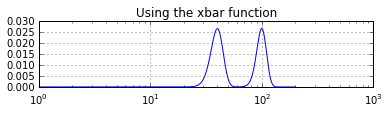

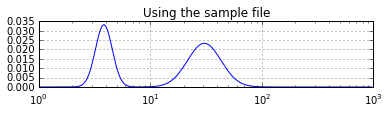

In [721]:
plt.figure(1)
plt.subplot(311)
plt.title('Using the xbar function')
x = np.linspace(0,200,N)
signal = xbar_func(x)
plt.xscale('log')
plt.grid(True)
plt.plot(x,signal)

plt.figure(2)
plt.subplot(312)
plt.title('Normpdf function')
x = np.linspace(0., 200., N)
plt.plot(x,signal2)
plt.grid(True)
plt.xscale('log')

plt.figure(3)
plt.subplot(313)
plt.title('Using the sample file')
x = np.loadtxt("x.txt")
plt.plot(T,x)
plt.xscale('log')
plt.grid(True)
plt.show()



For the rest of study we will consider using only the x.txt sample because it provides values in $[1, 10^3]$

#### 4. Create t using a regular sampling strategy

In [722]:
tmin = 0.
tmax = 1.5
M = 50

t = np.zeros(M)
for m in range(M):
    t[m] = tmin + tmax * (m / M) 

#### 5. Construction of the K(m,n) Matrix

$K^{(m,n)} = e^{(-T^{(n)}t^{(m)})}$

In [723]:
K = np.zeros((M,N))
for m in range(M):
    for n in range(N):
        K[m,n] = np.exp(-T[n] * t[m])

#### 6. noise simulation 

In [724]:
# z.shape = (50,200) x (200,) = (50,)
z = np.dot(K, x)

# first observation of z is in z[0]
sigma = 0.01 * z[0]

# w is a normal noise mean = 0, var = sigma^2
w = np.random.normal(0, sigma, z.shape)

# finaly y = z + w
y = z + w

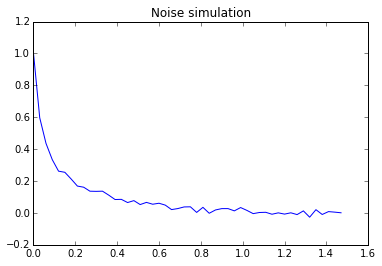

In [725]:
plt.plot(t,y)
plt.title("Noise simulation")

### 3. Comparaison of regularized strategies

We are given with three penalization functions $g(x)$. We want to find the $g(x)$ that minimizes $\bar{x}$.  

This problem is convex, lower-semicontinuous with a sum of coercive functions. There exists a solution but it is not always uniq.


#### 1. Smoothness prior

The regularization function is now:
$$(\forall x\in\mathbb{R}^{N}),\ g(x) = \frac{1}{2}\left \| Dx \right \|^{2}$$
$D\in\mathbb{R}^{NxN},$ discrete gradient operator defined by, 
$$
(\forall n = \{1, ..., N\}),\ [Dx]^{(n)} = x^{(n)} - x^{(n-1)} \\
(x^{(0)} = x^{(n)})
$$

$g(x)$ is a sum of $\Gamma(0)$ functions. Finaly optimization problem falls back to optimizing a least squares
which can be resumed in solving the following linear system 
$$(K^{T}K + \beta D^{T}D)x = K^{T}y$$

That is the established by finding were the derivative is null:
$$ \frac{\partial}{\partial x} \frac{1}{2}\left \| Kx -y \right \|^{^{2}} + \beta g(x) = 0$$

In [726]:
# circuvent with the circular convention
D = np.zeros((N,N))
for n in range(N):
    D[n, n] = 1
    if n > 0:
        D[n-1, n] = -1
D[N-1, 0] = -1

# np.set_printoptions(threshold=np.nan)
# np.set_printoptions(threshold=1000)
# print(D.shape, D)

# linear system solver
def solver(K, beta, D, y):
    return np.linalg.solve(np.dot(K.T,K) + \
                                     beta * np.dot(D.T, D), \
                                     np.dot(K.T,y))
# we will start using beta = 1
beta = 1
xestimate = solver(K, beta, D, y)

<IPython.core.display.Latex object>

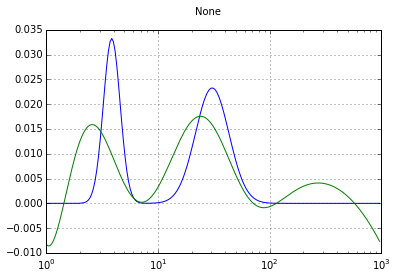

In [727]:
plt.figure(4)
plt.xscale('log')
plt.grid(True)
plt.suptitle(display(Latex(r'Smoothness prior $g(x) = \frac{1}{2}\left \| Dx \right \|^{2}$')))

x = np.loadtxt("x.txt")
plt.plot(T,x)
plt.plot(T,xestimate)
plt.show()


In [763]:
# Normalized quadratic error
def nqE(xestim, xbar):
    return np.sum ((xbar - xestim)**2 / np.sum(xbar**2))

print("Normalized Quadratic Error is %f"%(nqE(xestimate, x)))

Normalized Quadratic Error is 0.449717


In [730]:
# let's find the beta parameter that minimizes the nqE
loops = 100
beta = 0.1
nqe = []
for beta_idx in range(0,loops):
    xestimate = solver(K, beta, D, y)
    nqe.append(nqE(xestimate, x))
    beta += 0.1
plt.plot(nqe)
plt.grid(True)

#### 2. Smoothness prior with constraints

The problem is equivalent to the relaxed version but on a compact intervalle $[x_{min}, x_{max}]$.  
We consider $g(x)$ to be a sum of two functions

$$
g(x) = m(x) + n(x)\ with
\left\{\begin{matrix} 
    m(x) = \frac{1}{2}\left \| Dx \right \|^{2} \\ 
    n(x) = \imath_{ [x_{min}, x_{max}] } N(x) 
    \end{matrix}\right.\\
$$

we have $argmin(m + n) \neq 0$ and $m,n \in \Gamma_{0}\cal(H)$. Moreover n(x) is differntiable with a $\nu$-Lipschitzian gradient with $\nu \in\ ]0, +\infty[$'))
As a consequence, there is at least a solution that can be solved with using the forward/backward algorithm.

In [731]:
xmin = min(x)
xmax = max(x)
epsilon = np.finfo(float).eps


# nu-lipschitzian function => |f(x) - f(y)| <= nu * |x -y| d_x(f) <= nu
beta = 0.1
nu = np.linalg.norm(np.dot(K.T, K) + beta * np.dot(D.T, D))

# gamma is in ]0,2/nu[ let's take a value close to the higher bound
gamma = (2 - epsilon) / nu

# delta is in ]1,2[
delta = 2 - gamma * nu / 2 

#sigma(d) -> +inf with (lambda_n = 1)
lambda_n =1


print("\n beta = %f \n nu = %f \n gamma = %f \n delta = %f \n lambda_n = %f \n"%(beta, nu, gamma, delta, lambda_n))


 beta = 0.100000 
 nu = 501.242496 
 gamma = 0.003990 
 delta = 1.000000 
 lambda_n = 1.000000 



In [790]:
def init_params(beta):
    nu = np.linalg.norm(np.dot(K.T, K) + beta * np.dot(D.T, D))
    gamma = (2 - epsilon) / nu
    delta = 2 - gamma * nu / 2
    lambda_n =1
    # print("\n beta = %f \n nu = %f \n gamma = %f \n delta = %f \n lambda_n = %f \n"%(beta, nu, gamma, delta, lambda_n))
    return nu, gamma, delta, lambda_n
    
    
def gen_xn(x):
    return np.tile(epsilon, x.shape[0])


def grad_g(x):
    return np.dot(np.dot(K.T,K) + beta * np.dot(D.T,D),x) - np.dot(K.T,y)


def prox_gammaf(y):
    return np.maximum(np.minimum(xmax, y),xmin)


def forward_backward(xn, beta, loops):
    nu, gamma, delta, lambda_n = init_params(beta)
    for n in range(loops):
        yn = xn - gamma * grad_g(xn)
        xn = xn + lambda_n * (prox_gammaf(yn) - xn)
    return xn



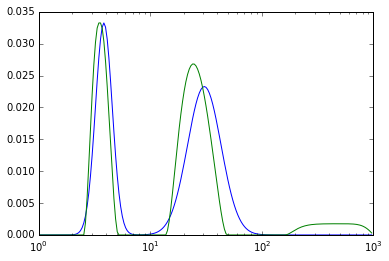

In [733]:
# beware with a huge loop!
loops = 50000
xn = gen_xn(x)
x_n = forward_backward(xn, beta, loops)
# by default timeit takes the average time of 3 run of its arguments
# %timeit loops = 10000 ; x_n = forward_backward(xn, beta, loops)

plt.plot(T,x)
plt.plot(T,x_n)
plt.xscale('log')

In [735]:
print("Normalized Quadratic Error is: %f"%(nqE(x_n, x)))

Normalized Quadratic Error is: 0.194015


In [736]:
fb_loops = 100
beta_loops = 100
beta = 0.1
nqe = []

for beta_idx in range(beta_loops):
    beta += 0.1
    xn = gen_xn(x)
    x_n = forward_backward(xn, beta, fb_loops)
    nqe.append(nqE(x_n, x))


In [737]:
plt.figure(5)
plt.xscale('log')
plt.grid(True)
plt.suptitle(display(Latex(r"""$\beta$ choice Smoothness prior with constraints $g(x) = m(x) + n(x) with \left\{\begin{matrix} m(x) = \frac{1}{2}\left \| Dx \right \|^{2} \\ n(x) = \imath_{ [x_{min}, x_{max}] } N(x) \end{matrix}\right.$""")))
plt.plot(nqe)

<IPython.core.display.Latex object>

#### 3. Sparsity prior

This time the penalization function is the the norm-1 function.  
Thus the problem is convex with a sum of lower-semicountinuous functions.  
There is a solution that can be found as before using the forward backward algorithm

In [791]:
def proximal_operator(x, q, chi):
    
    if q == 1:
        return np.sign(x) * np.max(np.abs(x) - chi, 0)
    
    elif q == 4/3:
        epsilon = np.sqrt(np.power(x,2) + 256 * np.power(chi,3)/729)
        return x + (4*chi/3*np.power(2,1/3)) * (np.power(epsilon - x,1/3) - np.power(epsilon + x,1/3))
    
    elif q == 3/2:
        return x + (9*np.power(chi,2)*np.sign(x)/8) * (1 - np.sqrt(1+16*np.abs(x)/(9*np.power(chi,2))))
    
    elif q == 2:
        return x/(1+2*chi)
    
    elif q == 3:
        return np.sign(x) * (np.sqrt(1+12*chi*np.abs(x)) - 1)/(6*chi)
    
    elif q == 4:
        epsilon = np.sqrt(np.power(x,2) + 1/(27*chi))
        return np.power((epsilon + x)/(8*chi),1/3) - np.power((epsilon - x)/(8*chi),1/3) 
    
    else:
        raise(ValueError("invalid value for q"))
        
vproximal_operator = np.vectorize(proximal_operator)

In [792]:
def vforward_backward(xn, beta, loops, q):
    nu, gamma, delta, lambda_n = init_params(beta)
    for n in range(loops):
        yn = xn - gamma * grad_g(xn)
        xn = xn + lambda_n * (vproximal_operator(yn, q, gamma*beta) - xn)
    return xn

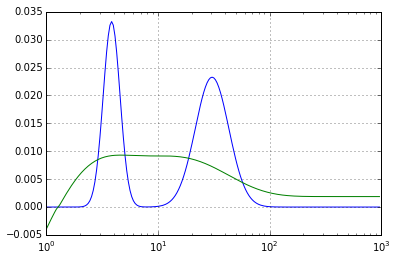

In [793]:
# beware with a huge loop!
# %timeit loops = 10000 ; x_n = vforward_backward(xn, beta, loops, 2)

x = np.loadtxt("x.txt")
xn = gen_xn(x)

loops = 100
x_n = vforward_backward(xn, beta, loops, 1)

plt.xscale('log')
plt.grid(True)
plt.plot(T,x)
plt.plot(T,x_n)
plt.show()



In [794]:
print("Normalized Quadratic Error is: %f"%(nqE(x_n, x)))

Normalized Quadratic Error is: 0.559874


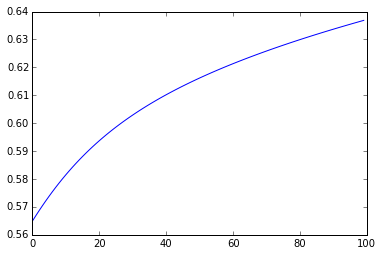

In [750]:
fb_loops = 100
beta_loops = 100
beta = 0.1
nqe = []

for beta_idx in range(beta_loops):
    beta += 0.1
    xn = gen_xn(x)
    x_n = vforward_backward(xn, beta, fb_loops, 1)
    nqe.append(nqE(x_n, x))
plt.plot(nqe)

## Part II - Maximum entropy regularization

Now the penalization function is an entropy function defined as follows

### 1) Caracteristics of the entropy function

The entropy function is a serie defined on $\mathbb{R}^{N}$

$$
(\forall x \in \mathbb{R^{N}})\ 
ent(x) = \sum_{n=1}^{N} \phi(x^{(n)}) \\
with,\ (\forall u \in \mathbb{R})\ 
\phi(u) = \left\{\begin{matrix}
 u log u & \text{if } u > 0, \\ 
 0 & \text{if } u = 0, \\ 
 +\infty & \text{elsewhere}
\end{matrix}\right.
$$

$ent(x)$ is proper because its definition domaine is not empty.    
To prove that ent(x) is convexe, the easiest way is to prove that the second order derivate is positive.  

$$
\begin{align*}
 \frac{\partial^{2}ent(x)}{\partial x^{2}} &= \sum_{n=1}^{N} \frac{\partial^{2}\phi(x^{(n)})}{\partial x^{2}} \\ 
 &= \sum_{n=1}^{N} \frac{1}{x^{(n)}} > 0 \Rightarrow ent(x) \text{ is convexe}
\end{align*}
$$


$$
\begin{align*}
\text{ent(x) is l.s.c.} & \Rightarrow \liminf_{x_{n}\to x} f(x_{n})\geq f(x) \\ 
 & \Rightarrow \liminf_{x_{n}\to x} \phi(x_{n})\geq 0 
 \left\{\begin{matrix}
 x \to 0^{+} \Rightarrow \phi(x_{n}) \to 0 & \ge 0\\ 
 x \to 0^{-} \Rightarrow \phi(x_{n}) \to +\infty & \ge 0\\
 \end{matrix}\right. \\
 & \Rightarrow ent(x) \text{ is differentiable}
\end{align*}
$$

and thus \phi is differentiable in the following set $\{ x\in \mathbb{R}^{N}, \prod_{n = 1}^{N} x_n \ne 0\}$


### 2) solution to the optimization problem


$ent(x)$ is convex, proper, lower-semi continuous, differentiable. Hence the optimization problem has a uniq solution


### 3) Proximal operator of the entropy function

The minimum is when the derivate is null:  
$$ 
\begin{align*}
 \frac{\partial\ ent(y^{(n)})}{\partial y^{(n)}} 
 +(y^{(n)} - x)= 0  
 & \Leftrightarrow (1 + log(y^{(n)})) + (y^{(n)} - x ) = 0 \\ 
 & \Leftrightarrow y^{(n)} = e^{-y^{(n)}+x-1}
\end{align*}
$$

This equation is a particular form the Lambert W-function:   

$$
\begin{align*}
    p^{ax+b} = cx + d  
\left\{\begin{matrix}
  p = e & \\ 
  a = -1 & \\
  b = x - 1 &\\
  c = 1 & \\
  d = 0 & \\
 \end{matrix}\right. \\
\end{align*}
$$


A generic term for the x that solve this equation is:  

$$
 y = xe^{x} \Leftrightarrow x = W(y) with
\left\{\begin{align*} 
 & W = f^{-1}(xe^{x})\\ 
 & y^{(n)} = W(e^{(x-1)})
\end{align*}\right.
$$

Let's prove it

$
\begin{align*}
  prox_{\gamma\ f} (x)\ = & \underset{y\in \mathbb{R}^{N}}{argmin} f(y) + \frac{1}{2\gamma} \left\|y-x\right|^2 \\  
  =\ &  \underset{y\in \mathbb{R}^{N}}{argmin} \sum_{n=1}^{N} y_n log y_n
  + \frac{1}{2\gamma} \sum_{n=1}^{N} (y_n-x_n)^2 (= g_{n}(y), \forall n \in \{1,...,N\}) \\
\end{align*}
$

We are looking for the $y_n \gt 0$, $\nabla g_n(y_n) = 0$

$$
\begin{align*}
  \nabla g_n = 0 \Leftrightarrow & \frac{1}{\gamma}y_n + log y_n = \frac{1}{\gamma}x_n - 1\\  
  \Leftrightarrow &  y_n e^{\frac{1}{\gamma}y_n} = e^{\frac{1}{\gamma}x_n - 1} \\
  \Leftrightarrow &  \frac{y_n}{\gamma} = W(\frac{1}{\gamma}e^{\frac{1}{\gamma}x_n - 1})\\
\end{align*}
$$

Hence, $\forall n \in \mathbb{N}, 1\le n\le N:prox_{\gamma\ f} (x)\ = \gamma  W(\frac{1}{\gamma}e^{\frac{1}{\gamma}x_n - 1})$



### 4) strategies to solve the problem

we want to solve the problem:  
$$ \widehat{x} = \underset{x\in \mathbb{R}^{N}}{argmin}\ \frac{1}{2}\left \| Kx -y \right \|^{^{2}} + \beta\ ent(x) $$

We re-calculate the proximal operator and obtain the generic form of a solution:  

$$
\left\{\begin{align*} 
 & y^{(n)} = e^{\frac{x-y^{(n)}}{\gamma}-1} \\
 & y = \gamma\ W(\frac{e^{\frac{x}{\gamma}-1}}{\gamma}
 )
\end{align*}\right.
$$

We will apply the forward backward algorithm with:  

$$
\left\{\begin{align} 
 & y_n = x_n - \gamma \nabla g(x_n) \\
 & x_n+1 = x_n + \lambda_n(prox_{\gamma f} y_n - x_n)
\end{align}\right.
$$

We chose the following parameters:  

$$
\left\{\begin{align*}
& \beta = 0.01 \\
& \nu = \left \| K^TK \right \|_2 \text{, the hessian of g} \\
& \gamma = \frac{2 - \epsilon}{\nu} \\
& \delta = 2 - \gamma \frac{\nu}{2} \\
& \lambda_n = 1
\end{align*}\right.
$$

### 5) Implementation and choice of $\beta$

#### 1. forward-backward algorithm

In [751]:
from scipy.special import lambertw

beta = 0.01
epsilon = np.finfo(float).eps

def init_params(beta):
    nu = np.linalg.norm(np.dot(K.T, K))
    gamma = (2 - epsilon) / nu
    lambda_n =1
    # print("\n beta = %f \n nu = %f \n gamma = %f \n lambda_n = %f \n"%(beta, nu, gamma, lambda_n))
    return gamma, lambda_n

def proximal_entropy(gamma,x):
    cpx = np.log(1/gamma) - 1 + x/gamma
    if cpx > 200:
        return gamma * (cpx - np.log(cpx))
    else:
        return gamma * (lambertw(np.exp(cpx)))
    
vprox_ent = np.vectorize(proximal_entropy)

def grad_gx(x):
    return np.dot(np.dot(K.T,K),x) - np.dot(K.T,y)

def gen_xnz(x):
    return np.zeros(x.shape[0])

def forward_backward_entropy(xn, beta, loops):
    gamma, lambda_n = init_params(beta)
    for n in range(loops):
        yn = xn - gamma * grad_gx(xn)
        xn = xn + lambda_n * (vprox_ent(gamma*beta, yn) - xn)
    return xn

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  copy=False, subok=True, dtype=otypes[0])
/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


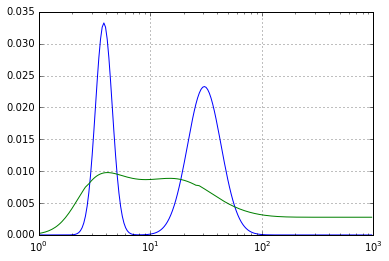

In [753]:
fb_loops = 1000
xnz = gen_xnz(x)
x_n = forward_backward_entropy(xnz, beta, fb_loops)

plt.plot(T,x)
plt.plot(T,x_n)
plt.xscale('log')
plt.grid(True)

In [755]:
print("Normalized Quadratic Error is: %f"%(nqE(x_n, x)))

Normalized Quadratic Error is: 0.546549


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  copy=False, subok=True, dtype=otypes[0])
/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


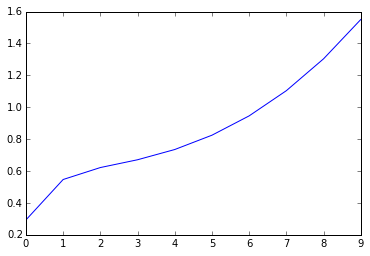

In [767]:
beta_loops = 10
nqe = []
beta = 0 + epsilon

for beta_idx in range(beta_loops):
    beta += 0.01 * beta_idx
    xnz = gen_xnz(x)
    x_n = forward_backward_entropy(xnz, beta, fb_loops)
    nqe.append(nqE(x_n, x))
plt.plot(nqe)

####  2. Douglas-Rachford algorithm

In [768]:
beta = 0.01
epsilon = np.finfo(float).eps

def init_params(beta):
    nu = np.linalg.norm(np.dot(K.T, K))
    gamma = (2 - epsilon) / nu
    lambda_n =1
    # print("\n beta = %f \n nu = %f \n gamma = %f \n lambda_n = %f \n"%(beta, nu, gamma, lambda_n))
    return gamma, lambda_n

def proximal_funct(gamma,x):
    A = np.eye(K.shape[1]) + gamma * np.dot(K.T,K)
    return np.dot(np.linalg.inv(A),x + gamma * np.dot(K.T,y))


def proximal_ent(gamma,x):
    cpx = np.log(1/gamma) - 1 + x/gamma
    if cpx > 200:
        return gamma * (cpx - np.log(cpx))
    else:
        return gamma * (lambertw(np.exp(cpx)))
proximal_entropy = np.vectorize(proximal_ent)


def douglas_rachford(xn, beta, loops):
    gamma, lambda_n = init_params(beta)
    for n in range(loops):
        yn = proximal_funct(gamma,xn)
        zn = proximal_entropy(gamma * beta,2 * yn - xn)
        xn = xn + lambda_n * (zn - yn)
    return xn

In [770]:
dr_loops = 1000
xnz = gen_xnz(x)
y_n = douglas_rachford(xnz, beta, dr_loops)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  copy=False, subok=True, dtype=otypes[0])


/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


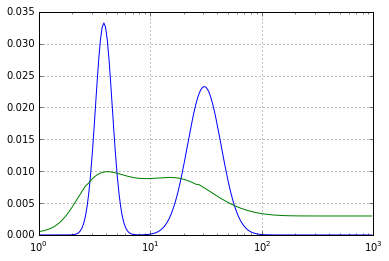

In [771]:
plt.plot(T,x)
plt.plot(T,y_n)
plt.xscale('log')
plt.grid(True)

In [772]:
print("Normalized Quadratic Error is: %f"%(nqE(y_n, x)))

Normalized Quadratic Error is: 0.549072


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  copy=False, subok=True, dtype=otypes[0])
/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


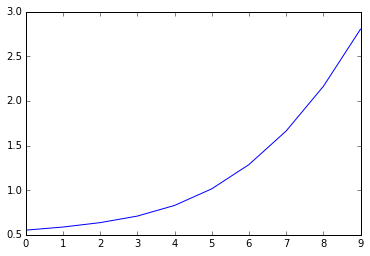

In [774]:
beta_loops = 10
nqe = []
beta = 0 + epsilon

for beta_idx in range(beta_loops):
    beta += beta_idx*0.01
    xnz = gen_xnz(x)
    y_n = douglas_rachford(xnz, beta, dr_loops)b
    nqe.append(nqE(y_n, x))
plt.plot(nqe)



### 8. We want to $\underset{x\in\mathbb{R^N}}{minimize}\ ent(x)$ with $\left \| Kx -y \right \|^{^{2}} \le \eta M \sigma^2$ 

This problem is equivalent to minimizing $ent(x)$ with $\iota_c$ in the convexe domaine.  
we can use PPXA+ algorithm

In [775]:
# force the shape of y_0 to rank_y, 1
y_0 = np.zeros((y.shape[0],1))
for i in range(y.shape[0]):
    y_0[i] = y[i]

In [776]:
def init_params(beta):
    nu = np.linalg.norm(np.dot(K.T,K))
    gamma = 1.9 / nu
    lambda_n = 1
    eta = 0.1
    eps = eta * M * (sigma**2)
    return gamma, lambda_n, eps


In [777]:
def proximal_ind_c(x, epsilon):
    t = x - y_0
    s = np.min([1 / np.linalg.norm(t) * epsilon,1]) * t
    p = x + s - t
    return p

In [778]:
beta = 0.001
loops = 50

xn_2, xn_1 = np.zeros((y.shape[0],1)), np.zeros((x.shape[0],1))
vn = np.dot(np.linalg.inv(np.dot(K.T,K) + np.eye(K.shape[1])),
            np.dot(K.T,xn_2) + xn_1)

for i in range(loops):
    gamma, lambda_n, epsilon = init_params(beta)
    
    yn_1 = proximal_entropy(gamma,xn_1)
    yn_2 = proximal_ind_c(xn_2, epsilon)
    
    cn = np.dot(np.linalg.inv(np.dot(K.T,K) + np.eye(K.shape[1])),np.dot(K.T,yn_2) + yn_1)
    xn_1 = xn_1 + lambda_n * (2. * cn - vn - yn_1)
    xn_2 = xn_2 + lambda_n * (np.dot(K,2 * cn - vn) - yn_2)
    vn = vn + lambda_n * (cn - vn)

In [781]:
plt.plot(T,x)
plt.plot(T,vn)
plt.xscale('log')
plt.grid(True)

/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
